# Task 1

In this task, we need to attempt to create a Deep Learning model that, given a sequence of images of Hurricanes, it will try to predict how the hurricane will be like at a future time.

In [1]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset, BatchSampler, DataLoader, Sampler

from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

Below, we define the dataset. In the 

In [2]:
class GroupedStormImageDataset(Dataset):
    """
    A custom dataset class for loading and transforming storm images grouped by storm events.

    Attributes:
        root_dir (str): The root directory where storm data is stored. Each subdirectory within
                        this directory represents a different storm event, containing images and
                        their corresponding feature metadata.
        transform (callable, optional): An optional transform to be applied on a sample image.
        storms (list): A list where each element is a list of tuples, with each tuple containing
                       the path to an image and its corresponding features loaded from a JSON file.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object, loading the dataset structure from the file system.


        Args:
            root_dir (str): The root directory path where the dataset is stored.
            transform (callable, optional): An optional transform to be applied on a sample.
        """
         
        self.root_dir = root_dir
        self.transform = transform
        self.storms = []  # List to store groups of images by storm

        # Iterate through each file in the storm directory
        for storm_dir in sorted(os.listdir(root_dir)):
            storm_path = os.path.join(root_dir, storm_dir)
            if os.path.isdir(storm_path):
                storm_data = []  # List to store image paths and features for the current storm
                for image_file in sorted(os.listdir(storm_path)):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(storm_path, image_file)
                        file_stem = image_file.split('.')[0]
                        features_json_path = os.path.join(storm_path, file_stem + '_features.json')
                        with open(features_json_path, 'r') as f:
                            features = json.load(f) # Load features from the JSON file
                        storm_data.append((image_path, features))
                self.storms.append(storm_data)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The total number of images across all storms.
        """
        return sum(len(storm) for storm in self.storms)

    def __getitem__(self, idx):
        """
        Retrieves a single sample from the dataset at the specified index. Good for memory efficiency

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the transformed image and its features.
        """
        for storm_data in self.storms:
            if idx < len(storm_data):
                img_path, feature = storm_data[idx]
                image = Image.open(img_path).convert('L')
                if self.transform:
                    image = self.transform(image)
                return image, feature
            idx -= len(storm_data) # Adjust index for the next group of storm data

In [6]:
# Example of what an element in the image dataset looks like.
dataset = GroupedStormImageDataset(root_dir='./Selected_Storms_curated_to_zip', transform=ToTensor())
dataset[0]

(tensor([[[0.2471, 0.3373, 0.4314,  ..., 0.0431, 0.0431, 0.0392],
          [0.2431, 0.3255, 0.4118,  ..., 0.0431, 0.0431, 0.0392],
          [0.2863, 0.3569, 0.4235,  ..., 0.0431, 0.0431, 0.0392],
          ...,
          [0.0588, 0.0627, 0.0667,  ..., 0.1647, 0.1843, 0.2039],
          [0.0627, 0.0667, 0.0706,  ..., 0.1725, 0.1882, 0.2039],
          [0.0588, 0.0667, 0.0706,  ..., 0.1647, 0.1804, 0.1922]]]),
 {'storm_id': 'bkh', 'relative_time': '0', 'ocean': '1'})

For our storm image dataset, each storm represents a different event with a series of images. We need to ensure that batches of data fed into the model are coherent and respect the boundaries of these events to ensure the model learns how a specific storm behaves. So, in order to not mix events, we use:

**GroupedStormSampler**

This custom sampler is designed to iterate over the dataset while maintaining the grouping by storm events. It ensures that the model sees all images from one storm before moving to the next, respecting the grouping in the data (the individual storms).

**GroupedBatchSampler**

Building on the GroupedStormSampler, the GroupedBatchSampler takes this a step further by making sure that each batch of data not only comes from the same storm but also follows a specified batch size (at most). This sampler respects the boundaries of each storm, ensuring that no batch contains data from two different storms. If we are at the boundary of two different storms, it will yield a batch size smaller than the maximum batch size.

See below for an example that showcases the use of these two classes.

In [3]:
class GroupedStormSampler(Sampler):
    """
    A custom sampler for iterating over items in a dataset grouped by storm events,
    ensuring that each iteration step progresses through a single storm's data.

    Attributes:
        data_source (Dataset): The dataset to sample from, expected to have a 'storms' attribute
                               that contains grouped data per storm.
        indices (list): A list of tuples where each tuple contains the start and end indices
                        for samples belonging to the same storm.
    """
    def __init__(self, data_source):
        self.data_source = data_source
        self.indices = [] # List to hold start and end indices for each storm's data
        idx = 0
        # Generate start and end indices for each storm
        for storm in self.data_source.storms:
            self.indices.append((idx, idx + len(storm))) # Append a tuple with start and end indices
            idx += len(storm) # Update index to the start of the next storm

    def __iter__(self):
        """
        Provides an iterator over the dataset indices, grouped by storm.

        Yields:
            int: The next index in the dataset, progressing through each storm's data sequentially.
        """
        for start, end in self.indices:
            yield from range(start, end) # Yield indices for the current storm

    def __len__(self):
        return sum(len(storm) for storm in self.data_source.storms)

class GroupedBatchSampler(BatchSampler):
    """
    A custom batch sampler that creates batches from samples that belong to the same storm,
    based on indices provided by a `GroupedStormSampler`.

    Attributes:
        batch_size (int): The size of each batch.
        drop_last (bool): Whether to drop the last batch if it's smaller than `batch_size`.
        data_source (Dataset): The dataset to sample from, expected to have an 'indices' attribute
                               that contains start and end indices for each storm's data.
    """
    def __init__(self, batch_size, data_source, drop_last=False):
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.data_source = data_source

    def __iter__(self):
        """
        Provides an iterator over the batches, ensuring each batch contains samples from the same storm.

        Yields:
            list: A list of indices for the next batch, all belonging to the same storm.
        """
        batch = [] # Temporary list to build up the current batch
        for storm_idx, (start, end) in enumerate(self.data_source.indices):
            for idx in range(start, end):
                batch.append(idx)
                if len(batch) == self.batch_size:
                    yield batch # Yield the current batch and reset for the next batch
                    batch = []
            # Handle the last batch for the current storm
            if batch and (not self.drop_last or len(batch) == self.batch_size):
                yield batch
                batch = [] # Reset for the next storm

    def __len__(self):
        if self.drop_last:
            # Sum over the integer division of storm lengths by batch size for each storm
            return sum(len(storm) // self.batch_size for storm in self.data_source.storms)
        else:
            # Sum over the ceiling division of storm lengths by batch size for each storm
            return sum((len(storm) + self.batch_size - 1) // self.batch_size for storm in self.data_source.storms)



In [4]:
# Create DataLoader with a batch size of 8
storm_sampler = GroupedStormSampler(dataset)
grouped_batch_sampler = GroupedBatchSampler(batch_size=8, data_source=storm_sampler)
storm_data_loader = DataLoader(dataset, batch_sampler=grouped_batch_sampler)

One can see below that, for a batch size of 8:

- The first batch is just the first 8 images of the hurricane
- The 51st batch (at the border between hurricane 1 and 2), we just return 2 images in the batch.
- The 52nd batch returns the first 8 images of the second hurricane.

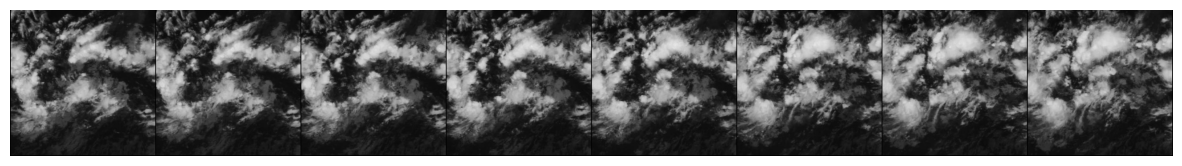

{'storm_id': ['bkh', 'bkh', 'bkh', 'bkh', 'bkh', 'bkh', 'bkh', 'bkh'], 'relative_time': ['0', '1801', '3600', '5400', '7200', '10802', '12602', '14402'], 'ocean': ['1', '1', '1', '1', '1', '1', '1', '1']}


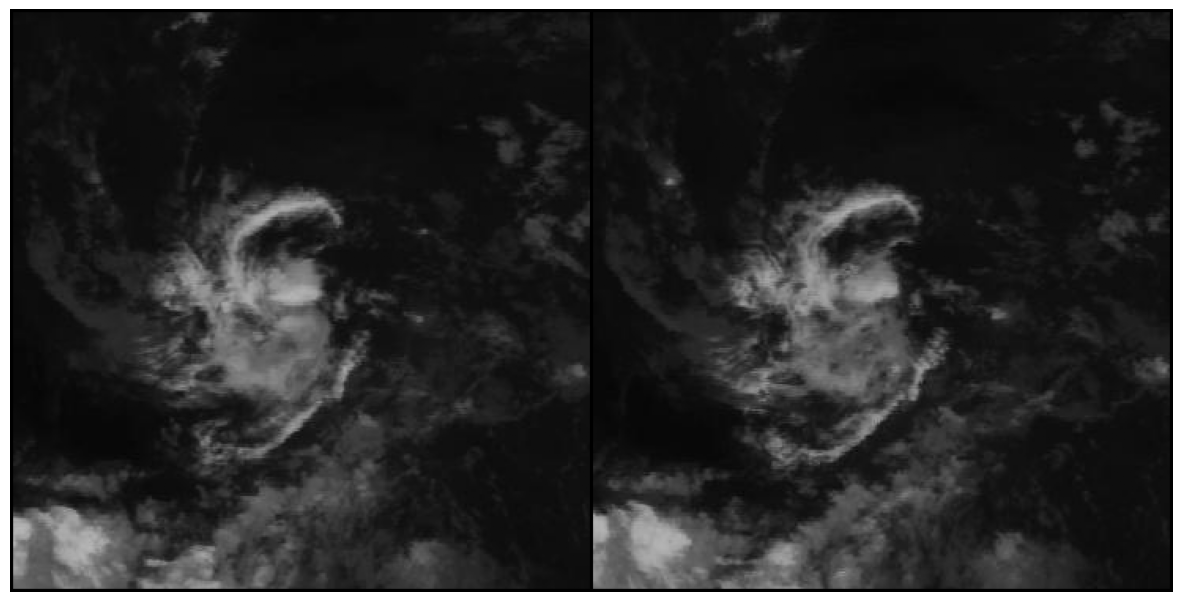

{'storm_id': ['bkh', 'bkh'], 'relative_time': ['1029601', '1031401'], 'ocean': ['1', '1']}


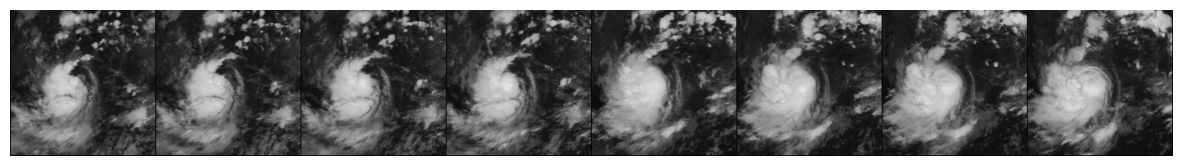

{'storm_id': ['blq', 'blq', 'blq', 'blq', 'blq', 'blq', 'blq', 'blq'], 'relative_time': ['0', '1801', '3600', '5400', '12598', '16199', '17998', '21598'], 'ocean': ['1', '1', '1', '1', '1', '1', '1', '1']}


In [5]:
# Helper function to visualize a batch of images
def visualize_batch(images):
    img_grid = make_grid(images, nrow=len(images))
    plt.figure(figsize=(15, 15))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Fetch and visualize the second batch
second_batch_images = None
for i, (images, data) in enumerate(storm_data_loader):
    if i == 0:
        second_batch_images = images
        visualize_batch(images)
        print(data)
        break

second_batch_images = None
for i, (images, data) in enumerate(storm_data_loader):
    if i == 51:
        second_batch_images = images
        visualize_batch(images)
        print(data)
        break

second_batch_images = None
for i, (images, data) in enumerate(storm_data_loader):
    if i == 52:
        second_batch_images = images
        visualize_batch(images)
        print(data)
        break